## Code example: Using neural network to predict digits with MNIST dataset

### Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F     
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
%matplotlib inline

### Load the MNIST dataset

In [2]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

Take a look at data

In [3]:
print(f'Number of training data: {len(train_data)}')
print(f'Number of test data: {len(test_data)}')

Number of training data: 60000
Number of test data: 10000


In [4]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [5]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


View the image

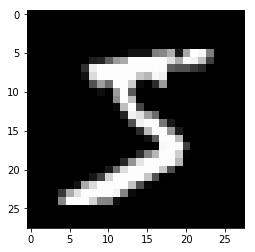

In [6]:
plt.imshow(image.reshape((28,28)), cmap="gray");

Batch loading with DataLoader

In [7]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)
type(train_loader)

torch.utils.data.dataloader.DataLoader

### Define the NN model

In [8]:
class NeuralNet(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.softmax(X, dim=1)

In [9]:
torch.manual_seed(101)
model = NeuralNet()
model

NeuralNet(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Define loss function & optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Flatten the training data
The batch tensors fed in by DataLoader have a shape of [100, 1, 28, 28]:

In [11]:
# Load the first batch, print its shape
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break

Batch shape: torch.Size([100, 1, 28, 28])


In [12]:
images.view(100,-1).size()

torch.Size([100, 784])

### Train the model

In [13]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1)) 
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b % 200 == 0:
            print(f'epoch: {i:2}  batch: {b:4}  loss: {loss.item():10.8f}  accuracy: {trn_corr.item() * 100 / (100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')  

epoch:  0  batch:  200  loss: 1.60853434  accuracy:  78.615%
epoch:  0  batch:  400  loss: 1.59832835  accuracy:  84.560%
epoch:  0  batch:  600  loss: 1.57792830  accuracy:  86.998%
epoch:  1  batch:  200  loss: 1.56021082  accuracy:  92.575%
epoch:  1  batch:  400  loss: 1.52542007  accuracy:  92.875%
epoch:  1  batch:  600  loss: 1.52330661  accuracy:  93.195%
epoch:  2  batch:  200  loss: 1.54607058  accuracy:  94.640%
epoch:  2  batch:  400  loss: 1.53161335  accuracy:  94.675%
epoch:  2  batch:  600  loss: 1.50149643  accuracy:  94.845%
epoch:  3  batch:  200  loss: 1.49138582  accuracy:  95.755%
epoch:  3  batch:  400  loss: 1.50433457  accuracy:  95.745%
epoch:  3  batch:  600  loss: 1.52251339  accuracy:  95.760%
epoch:  4  batch:  200  loss: 1.50399601  accuracy:  96.350%
epoch:  4  batch:  400  loss: 1.48152852  accuracy:  96.453%
epoch:  4  batch:  600  loss: 1.51158965  accuracy:  96.448%
epoch:  5  batch:  200  loss: 1.48446965  accuracy:  96.890%
epoch:  5  batch:  400  

### Plot the loss and accuracy comparisons

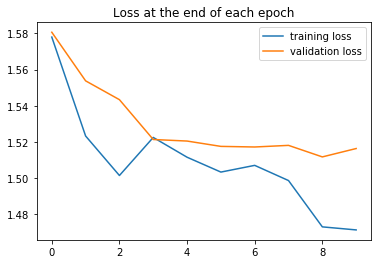

In [14]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

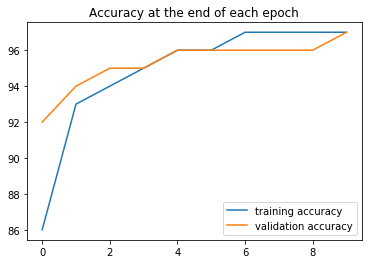

In [15]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

### Evaluate Test Data

In [16]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [17]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9727/10000 =  97.270%


### Display the confusion matrix

In [18]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 969    0    5    1    1    3    5    2    3    5]
 [   0 1124    2    0    0    0    3    6    0    3]
 [   0    3  994    6    5    0    0   10    2    0]
 [   2    1    9  984    0    8    1    5    5    6]
 [   1    0    1    0  965    1    2    8    5   24]
 [   0    1    0    2    0  865    4    0    3    5]
 [   3    1    4    0    5    4  938    0    4    0]
 [   1    2    7    6    2    0    0  990    4    6]
 [   4    3   10   11    2    8    5    1  946    8]
 [   0    0    0    0    2    3    0    6    2  952]]
